In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
from numpy import fft
from scipy import fft as sfft
from scipy.stats import norm

import emcee


**Fourier analysis**

In [2]:
data=pd.read_csv('Sunspots_observations.csv',names=['Year','Year_data','To_Delete','Month','Month_Data'])
data.iloc[618:,:]  # 1800 starts at index 620

,Year,Year_data,To_Delete,Month,Month_Data
618,NaN,NaN,NaN,1799.874,4.5
619,NaN,NaN,NaN,1799.958,14.3
620,NaN,NaN,NaN,1800.042,11.5
621,NaN,NaN,NaN,1800.123,15.5
622,NaN,NaN,NaN,1800.204,23.2
...,...,...,...,...,...
3293,NaN,NaN,NaN,2022.79,95.4
3294,NaN,NaN,NaN,2022.873,77.6
3295,NaN,NaN,NaN,2022.958,113.1
3296,NaN,NaN,NaN,2023.042,143.6


In [3]:
data=data.iloc[620:,:]
data.head()

,Year,Year_data,To_Delete,Month,Month_Data
620,NaN,NaN,NaN,1800.042,11.5
621,NaN,NaN,NaN,1800.123,15.5
622,NaN,NaN,NaN,1800.204,23.2
623,NaN,NaN,NaN,1800.288,0
624,NaN,NaN,NaN,1800.371,8.3


In [4]:
monthly_data=data['Month_Data'].squeeze().astype(float)

In [5]:
monthly_data_np=np.asarray(monthly_data)
monthly_data_np=monthly_data_np-np.mean(monthly_data_np)

2678


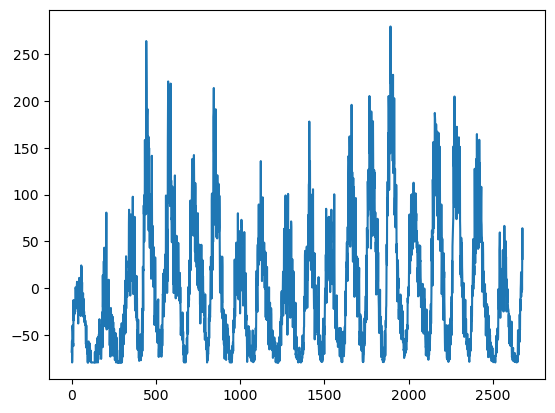

In [6]:
plt.plot(monthly_data_np)
print(len(monthly_data_np))

In [7]:
def eliminate_frequency(signal):
    n=len(signal)
    transform_i=sfft.fft(signal)
    frequencies_i=sfft.fftfreq(n)

    idxmax=np.argmax(np.absolute(transform_i))
    max_f=frequencies_i[idxmax]
    max_t=transform_i[idxmax]

    to_subtract=np.zeros(n)
    A=np.real(max_t)/n
    B=np.imag(max_t)/n
    for i in range(n):
        to_subtract[i]=2*A*(np.cos(2*np.pi*i*max_f))-2*B*(np.sin(2*np.pi*i*max_f))

    new_signal=signal-to_subtract
    new_signal=new_signal-np.mean(new_signal)
    return new_signal,1/max_f,2*((A**2+B**2)**0.5),int(A < 0) *np.pi+np.arctan(B/A)

In [8]:
signal=np.copy(monthly_data_np)

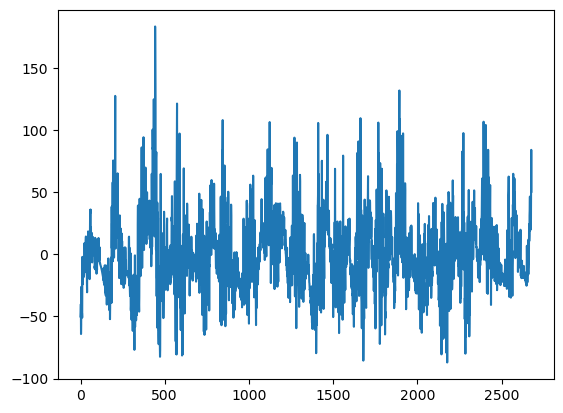

In [9]:
amplist=[]
plist=[]
phaselist=[]
for i in range(15):
    signal,maxp,amp,phase=eliminate_frequency(signal)
    amplist.append(amp)
    phaselist.append(phase)
    plist.append(maxp)
plt.plot(signal)

In [10]:
n=len(signal)
reconstructed=np.zeros(n)
for i in range(len(plist)):
    amp=amplist[i]
    phase=phaselist[i]
    max_p=plist[i]
    for j in range(n):
        reconstructed[j] += amp*np.cos(2*np.pi*j/max_p+phase)

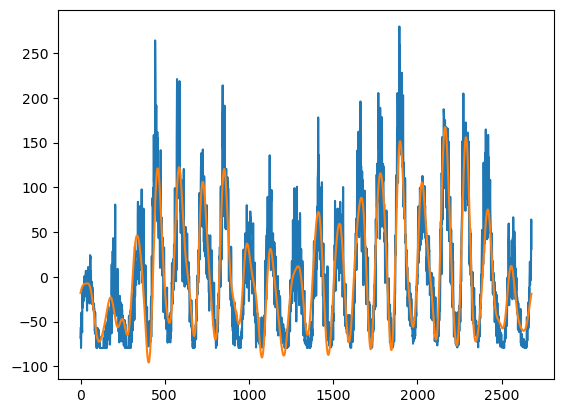

In [11]:
plt.plot(monthly_data_np)
plt.plot(reconstructed)

In [12]:
(np.mean((monthly_data_np-reconstructed)**2))**0.5  # White noise of first reconstruction

30.188915815736646

**MCMC** **Sampling**

In [13]:
theta0=np.asarray(amplist+plist+phaselist+[(np.mean((monthly_data_np-reconstructed)**2))**0.5]) # Empirical estimate of standard error
N=len(monthly_data_np)

In [14]:
print(theta0)

[ 4.22967469e+01  3.98392487e+01  3.21744617e+01  3.06548113e+01
  2.88648296e+01  1.37830734e+01  1.30827284e+01  1.06543089e+01
  9.97729787e+00  9.34811965e+00  9.23426941e+00  8.94705168e+00
  8.70940755e+00  8.25293945e+00  8.14399628e+00  1.33900000e+02
  1.27523810e+02  1.21727273e+02  1.33900000e+03  1.40947368e+02
  9.56428571e+01  2.67800000e+03  8.92666667e+02  6.53170732e+01
  4.46333333e+02  1.16434783e+02  1.03000000e+02  1.07120000e+02
  6.86666667e+01  2.67800000e+02  4.11089719e+00  5.55609888e-01
  1.56312385e+00  3.16318363e+00 -1.40965841e+00  1.32324480e+00
  2.03924190e+00  2.03608084e+00  1.98437879e-01 -3.16221588e-01
  4.34535056e+00  4.51338829e+00  3.86704522e+00  3.64397536e+00
 -8.62369106e-01  3.01889158e+01]


In [15]:
def generate_predictions(theta,N=N):  # Given theta, reconstructs signal
    amplist=theta[0:15]
    plist=theta[15:30]
    phaselist=theta[30:45]
    times=np.arange(N)
    ypred=np.zeros(N)
    for i in range(15):
        amp=amplist[i]
        p=plist[i]
        phase=phaselist[i]
        ypred += amp*np.cos(2*np.pi*times/p+phase)
    return ypred

In [16]:
def log_likelihood(theta,y=monthly_data_np,N=N):  # Log-likelihood
    amplist=theta[0:15]
    plist=theta[15:30]
    phaselist=theta[30:45]
    sigma=theta[45]
    term1=-N*np.log(sigma)
    times=np.arange(N)
    ypred=np.zeros(N)
    for i in range(15):
        amp=amplist[i]
        p=plist[i]
        phase=phaselist[i]
        ypred += amp*np.cos(2*np.pi*times/p+phase)
    term2=-1/(2*sigma**2)*np.linalg.norm(y-ypred)**2
    return term1+term2

In [17]:
def log_prior(theta):
    amplist=theta[0:15]
    diff=-np.diff(amplist)
    amp_descending=np.all(np.greater(diff,0))
    flist=theta[15:30]
    phaselist=theta[30:45]
    
    #Bounds: amplitudes and frequencies >0, removing periodicity from phases, and mantaining the order of frequencies
    if np.all(np.greater(amplist,0)) and np.all(np.greater(flist,0)) and np.all(np.greater(phaselist,-np.pi/2)) and np.all(np.less(phaselist,3*np.pi/2)) and theta[-1] > 0 and amp_descending:
        return -np.log(theta[-1])
    return -np.inf

In [18]:
def log_posterior(theta):  # Posterior
    lp=log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(theta)

In [19]:
log_posterior(theta0)   # Posterior of starting point

-10467.625072359704

In [20]:
n_walkers=128   # We need at least dim*2 walkers to use Red-Blue moves
pos=np.asarray([theta0 for i in range(n_walkers)])  # Initialize walkers in a Gaussian ball around starting estimate
pos +=1e-2*np.random.randn(n_walkers,46)
                  
start_posteriors=[log_posterior(theta) for theta in pos]
print(np.mean(start_posteriors))  # Want to make sure starting positions are within boundaries
print(np.max(start_posteriors))

-10468.283342774925
-10465.169786854925


In [143]:
sampler.reset()

In [21]:
# We use the DEMove to propose new points, as it was the best performing move in terms of autocorrelation
sampler=emcee.EnsembleSampler(n_walkers,46,log_posterior,moves=emcee.moves.DEMove())
last_sample=sampler.run_mcmc(pos,50000)

In [22]:
print(sampler.acceptance_fraction)

[0.09206 0.0911  0.10014 0.09848 0.0958  0.0979  0.09914 0.1004  0.09754
 0.0917  0.09552 0.09678 0.09694 0.09594 0.09024 0.09486 0.10226 0.09494
 0.09182 0.09392 0.09236 0.09186 0.09244 0.0987  0.09822 0.09322 0.09526
 0.09806 0.09624 0.09822 0.09352 0.10118 0.09778 0.09756 0.09872 0.0963
 0.09186 0.09752 0.09394 0.09524 0.09336 0.09804 0.09428 0.09908 0.09526
 0.09736 0.09098 0.09572 0.09682 0.09456 0.09888 0.09484 0.09626 0.09118
 0.09716 0.09792 0.1007  0.09284 0.09868 0.09018 0.0955  0.10168 0.09846
 0.09594 0.09794 0.1007  0.09558 0.09602 0.09432 0.09352 0.10328 0.09714
 0.09776 0.09766 0.0962  0.09788 0.0935  0.09358 0.098   0.09732 0.09492
 0.09978 0.0978  0.09246 0.0987  0.09806 0.09246 0.09662 0.098   0.09554
 0.09158 0.09782 0.10106 0.094   0.094   0.09548 0.09266 0.09476 0.09508
 0.0923  0.09816 0.0935  0.09646 0.09704 0.09518 0.09516 0.09362 0.09282
 0.09432 0.0959  0.08988 0.10066 0.0937  0.1004  0.0863  0.09462 0.10148
 0.09752 0.0973  0.09664 0.09792 0.09354 0.0981  0.0

In [26]:
autocorr=sampler.get_autocorr_time()

511.29302133580677


In [27]:
corr=np.mean(autocorr)
print(corr)

511.29302133580677


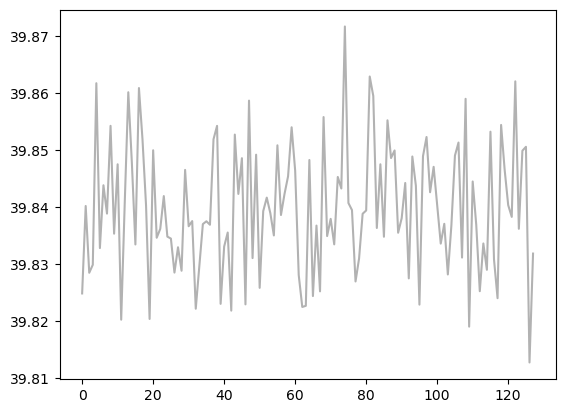

In [23]:
samples=sampler.get_chain()   #Visualize the chain for a single walker and parameter
plt.plot(samples[2, :, 1], "k", alpha=0.3)

In [24]:
flat_samples= sampler.get_chain(discard=1000, thin=250, flat=True)  # Thin by half average autocorr time, discard autocorrelation * 2 for burn in
means=np.asarray([np.mean(flat_samples[:,i]) for i in range(46)])
amps=[means[i] for i in range(15)]

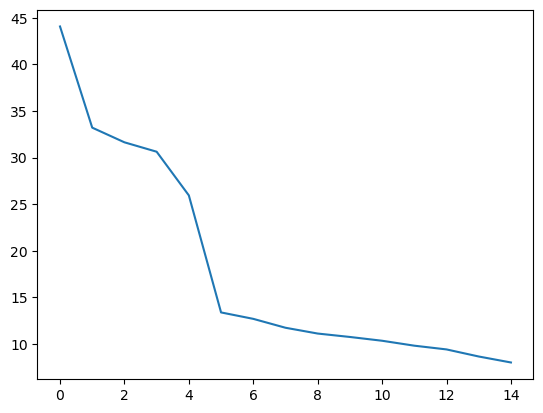

In [28]:
plt.plot(amps)

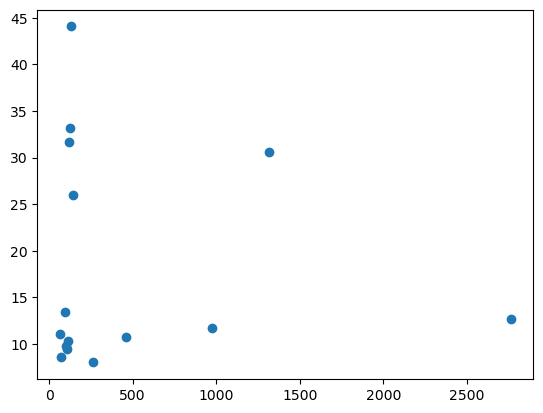

In [29]:
plt.scatter(means[15:30],amps)

(array([2.000e+00, 6.000e+00, 2.200e+01, 7.800e+01, 1.920e+02, 3.900e+02,
        7.850e+02, 1.354e+03, 1.984e+03, 2.452e+03, 2.782e+03, 2.800e+03,
        2.651e+03, 2.265e+03, 1.832e+03, 1.521e+03, 1.120e+03, 8.610e+02,
        6.030e+02, 4.430e+02, 3.230e+02, 2.290e+02, 1.420e+02, 8.800e+01,
        6.500e+01, 4.400e+01, 2.700e+01, 1.400e+01, 6.000e+00, 7.000e+00]),
 array([132.17800133, 132.23297109, 132.28794084, 132.3429106 ,
        132.39788035, 132.45285011, 132.50781986, 132.56278962,
        132.61775937, 132.67272913, 132.72769888, 132.78266864,
        132.83763839, 132.89260815, 132.9475779 , 133.00254766,
        133.05751741, 133.11248717, 133.16745693, 133.22242668,
        133.27739644, 133.33236619, 133.38733595, 133.4423057 ,
        133.49727546, 133.55224521, 133.60721497, 133.66218472,
        133.71715448, 133.77212423, 133.82709399]),
 <BarContainer object of 30 artists>)

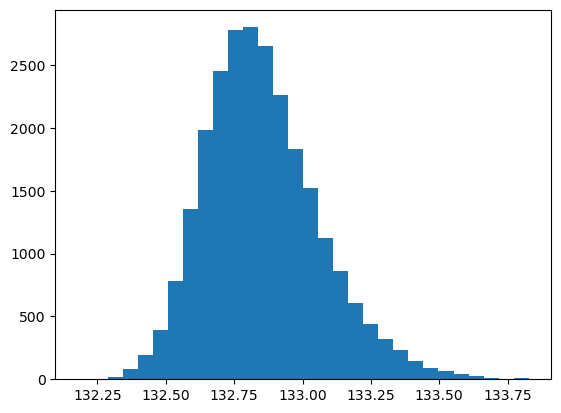

In [30]:
var=flat_samples[:,15]
plt.hist(var,bins=30)

In [151]:
(mu,sigma)=norm.fit(flat_samples[:,15])  # Fit gaussian to distribution of main period

In [152]:
print(mu)

132.86798781056513


In [153]:
print(sigma)

0.2258808834932943


In [31]:
def gaussian(x,mu,sigma):
    return 1/(sigma*(2*np.pi)**0.5)*np.exp(-0.5*((x-mu)/sigma)**2)

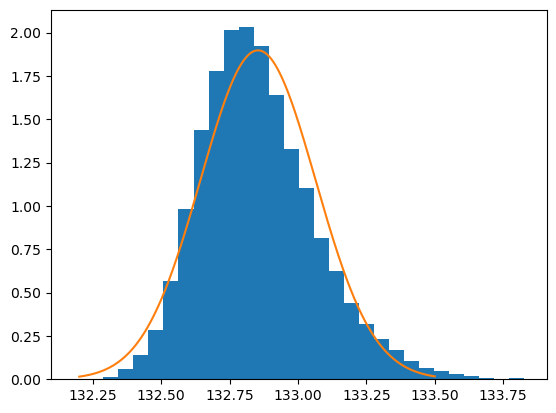

In [32]:
index=15   # Distribution and fitted gaussian
var=flat_samples[:,index]
(mu,sigma)=norm.fit(var)
x_vect=np.linspace(132.2,133.5,num=500)
gauss_line=[gaussian(x,mu,sigma) for x in x_vect]
plt.hist(var,bins=30,density=True)
plt.plot(x_vect,gauss_line)

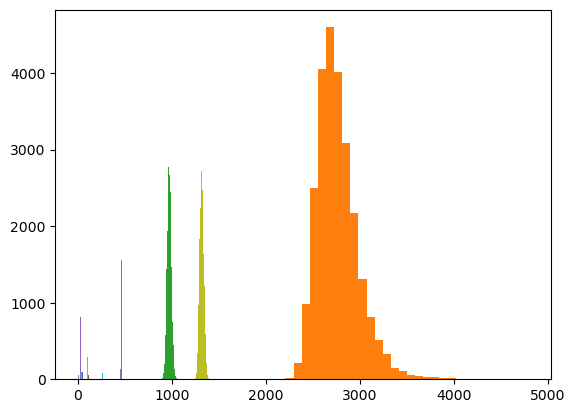

In [33]:
new_theta=[]
for i in range(46):
    n,bins,patches=plt.hist(flat_samples[:,i],bins=30)  
    max_i=np.argmax(n)
    new_theta.append((bins[max_i]+bins[max_i+1])/2)

In [34]:
new_theta   # Vector of modes of posterior

[44.826301622958574,
 32.849039717720935,
 31.52867396001791,
 30.683767880409142,
 26.05873714356228,
 13.297145845751775,
 12.675401459561026,
 11.757804932036347,
 11.184869904452551,
 10.822813830268824,
 10.396812602071595,
 9.857523899705715,
 9.363998083642107,
 8.732188396588084,
 8.103446282589791,
 132.81015351580493,
 127.51449707594084,
 121.06181356768377,
 1314.6899003200801,
 141.151553257155,
 96.11835380288696,
 2683.2254411661143,
 970.9936888883233,
 65.4736532565675,
 460.4922618667531,
 114.51283825328534,
 102.64223883019189,
 107.38411210726247,
 68.9853735984968,
 263.56561392479625,
 3.609061010553304,
 0.35750282466777017,
 1.2389350554837049,
 2.996688914050071,
 -1.127706906706229,
 1.8578194131457675,
 2.0062829463976017,
 2.7661593670322135,
 0.45111028498277306,
 0.24106922656739405,
 2.7609266915782573,
 4.152559301740576,
 3.956689953931643,
 4.061898565266334,
 -1.548803327030518,
 29.261701325357613]

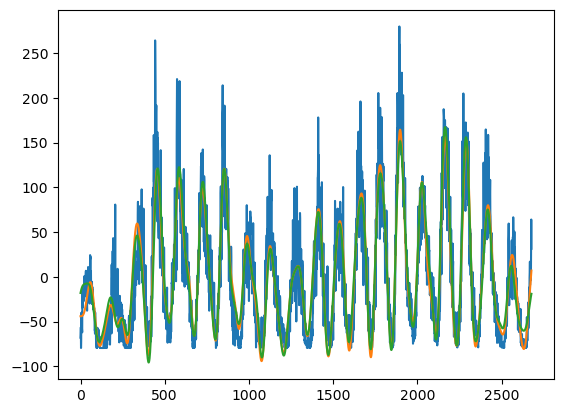

In [35]:
new_reconstruct=generate_predictions(new_theta)   # Compare starting point with new reconstruction and the signal
plt.plot(monthly_data_np)
plt.plot(new_reconstruct)
plt.plot(reconstructed)

Power_divergenceResult(statistic=1.7072836112739034, pvalue=0.9999999999998643)

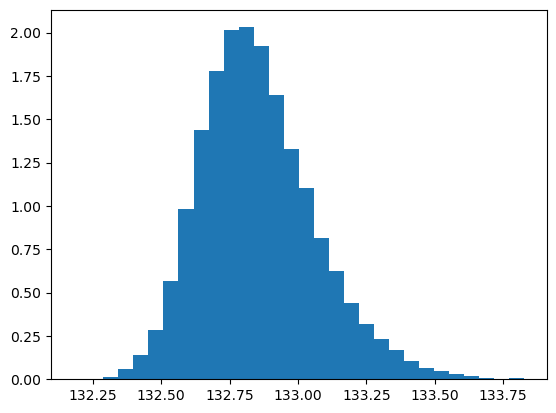

In [36]:
# Calculate chisquare of fit
import scipy
n,bins,patches=plt.hist(flat_samples[:,15],bins=30,density=True) 
points=[(bins[i]+bins[i+1]) /2 for i in range(len(bins)-1)]
est_density=np.asarray([gaussian(x,mu,sigma) for x in points])
est_density *= sum(n)/sum(est_density)
scipy.stats.chisquare(n,est_density)

In [37]:
log_posterior(new_theta)

-10372.23326160625

In [38]:
(np.mean((monthly_data_np-new_reconstruct)**2))**0.5  # The white noise has slightly reduced

29.13226558046655